In [1]:
import distl
import numpy as np

[DistributionCollections](../api/DistributionCollection.md) allow for sampling (and computing probabilities) on multiple distributions simultaneously, respecting any covariances between the distributions within that set.

# "Simple Case" (Univariate only)

Let's first look at the simplest case possible with two univariate distributions.  As these will be drawn independently, there is little gained by using a [DistributionCollection](../api/DistributionCollection.md) over simply handling the two objects separately, but this example shows the syntax without having to deal with complex subtle points.

In [2]:
g = distl.gaussian(10, 2, label='gaussian')
u = distl.uniform(0, 5, label='uniform')

In [3]:
dc = distl.DistributionCollection(g, u)

In [4]:
dc

When calling [sample](../api/DistributionCollection.sample.md), values are returned for each distribution in the order they were passed when initializing the object.

In [5]:
dc.sample()

array([7.94423774, 2.69269767])

If ever unsure, we can access the underlying distribution objects via the [dists](../api/DistributionCollection.dists.md) or [labels](../api/DistributionCollection.labels.md) properties.

In [6]:
dc.dists

[<distl.gaussian loc=10.0 scale=2.0 label=gaussian>,
 <distl.uniform low=0.0 high=5.0 label=uniform>]

In [7]:
dc.labels

['gaussian', 'uniform']

If passing `size` to [sample](../api/DistributionCollection.sample.md), we get a matrix with shape (`size`, `len(distributions)`)

In [8]:
dc.sample(size=3)

array([[ 8.28286113,  1.00086038],
       [13.31487454,  2.78179522],
       [12.11432159,  4.75435839]])

We can also call [plot](../api/DistributionCollection.plot.md) or [plot_sample](../api/DistributionCollection.plot_sample.md).  Here we're shown a corner plot and see that the samples were drawn independently (without any covariances).

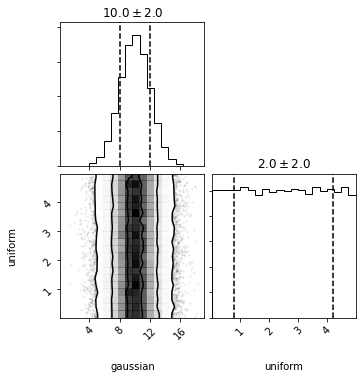

In [9]:
out = dc.plot(show=True)

Additionally, we can access [pdf](../api/DistributionCollection.pdf.md), [logpdf](../api/DistributionCollection.logpdf.md), [cdf](../api/DistributionCollection.cdf.md), and [logcdf](../api/DistributionCollection.logcdf.md). These all take a single argument which must be a list/tuple/array with the same length as the number of distributions.

In [10]:
dc.pdf([10, 5])

0.039894228040143274

To see the underlying distributions and the values that will be passed to the `pdf` method on each of those distributions, we can pass the same arguments to [get_distributions_with_values](../api/DistributionCollection.get_distributions_with_values.md).

In [11]:
dc.get_distributions_with_values([10,5])

{<distl.gaussian loc=10.0 scale=2.0 label=gaussian>: 10,
 <distl.uniform low=0.0 high=5.0 label=uniform>: 5}

From this we can see that, in the case of univariate distributions, pdf and cdf will be simply the product of the values from the children distributions, and logpdf and logcdf the sums.  However, this is where subtle complications come into place with [Composite](../api/Composite.md) and Multivariate distributions, which we'll see in the next few sections.

In [12]:
g.pdf(10) * u.pdf(5)

0.039894228040143274

# MultivariateSlice distributions

Note that each distribution passed to a collection must be a univariate or multivariate-slice.  If attempting to pass a multivariate object without slicing to a single dimension, an error will be raised.

First we'll create a [gaussian](../api/distl.gaussian.md), [uniform](../api/distl.uniform.md), and [multivariate gaussian](../api/distl.mvgaussian.md) distributions.

In [13]:
g = distl.gaussian(10, 2, label='gaussian')
u = distl.uniform(0, 5, label='uniform')
mvg = distl.mvgaussian([5,10, 12], 
                       np.array([[ 2,  1, -1], 
                                 [ 1,  2,  1], 
                                 [-1,  1,  2]]),
                       allow_singular=True,
                       labels=['mvg_a', 'mvg_b', 'mvg_c'])

Now let's imagine a scenario where we want to draw from the following sub-distributions: 'gaussian', 'uniform', 'mvg_a', and 'mvg_c' (but let's say we don't want 'mvg_b').  Here we want to *maintain* the covariances between 'mvg_a' and 'mvg_c' while *independently* sampling from 'gaussian' and 'uniform'.

Yes, in theory you could call sample on `g`, `u`, `mvg` and just ignore the second index in the returned arrays from `mvg.sample`... but a [DistributionCollection](../api/DistributionCollection.md) starts to provide some convenience in this case for both plotting and accessing the probabilities of a given drawn sample.  This becomes especially useful when coupled with [sample caching](./sample_cache.ipynb).

To learn more about slicing multivariate distributions, see [multivariate slicing](./multivariate_slice.ipynb), but in simple terms it allows you to select a single dimension from a multivariate distribution, acting like a univariate distribution but still retaining the underlying covariances of the multivariate distribution.

In [14]:
dc = distl.DistributionCollection(g, u, mvg.slice('mvg_a'), mvg.slice('mvg_c'))

In [15]:
dc.sample()

array([10.89082164,  0.71643591,  7.27132426, 11.88263208])

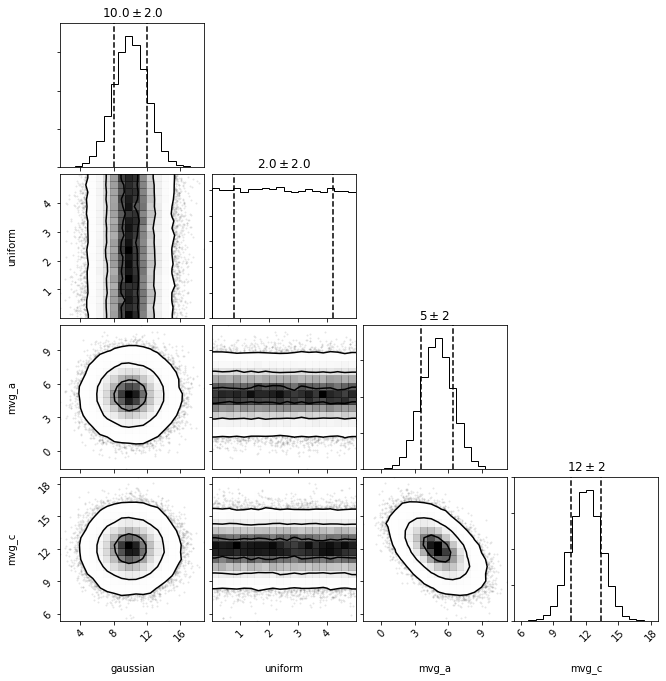

In [16]:
out = dc.plot(show=True)

As in the univariate case, [pdf](../api/DistributionCollection.pdf.md) takes a tuple/list/array.  This time, the pdf will account for the covariance between 'mvg_a' and 'mvg_c', by default.  As 'mvg_b' is not included, no value will be assumed, but rather will be marginalized over (via [take_dimensions](../api/BaseMultivariateDistribution.take_dimensions.md), see [multivariate examples](./multivariate.ipynb) for more details).

In [17]:
dc.labels

['gaussian', 'uniform', 'mvg_a', 'mvg_c']

In [18]:
dc.pdf([10, 5, 5, 11])

0.0026266653362734885

which could be computed manually as:

In [19]:
dc.get_distributions_with_values([10, 5, 5, 11])

{<distl.gaussian loc=10.0 scale=2.0 label=gaussian>: 10,
 <distl.uniform low=0.0 high=5.0 label=uniform>: 5,
 <distl.mvgaussian mean=[ 5 12] cov=[[ 2 -1]
  [-1  2]] allow_singular=False labels=['mvg_a', 'mvg_c']>: [5, 11]}

In [20]:
g.pdf(10) * u.pdf(5) * mvg.take_dimensions(['mvg_a', 'mvg_c']).pdf([5, 11])

0.0026266653362734885

To avoid this behavior and instead sum/multiply over the flattened univariate versions of each of the sampled parameters, pass `as_univariates=True` to [pdf](../api/DistributionCollection.pdf.md).

In [21]:
dc.pdf([10, 5, 5, 11], as_univariates=True)

0.0024724446692818785

which could be computed manually as:

In [22]:
dc.get_distributions_with_values([10, 5, 5, 11], as_univariates=True)

{<distl.gaussian loc=10.0 scale=2.0 label=gaussian>: 10,
 <distl.uniform low=0.0 high=5.0 label=uniform>: 5,
 <distl.mvgaussianslice dimension=0 mean=[5, 10, 12] cov=[[ 2  1 -1]
  [ 1  2  1]
  [-1  1  2]] allow_singular=True label=mvg_a)>: 5,
 <distl.mvgaussianslice dimension=2 mean=[5, 10, 12] cov=[[ 2  1 -1]
  [ 1  2  1]
  [-1  1  2]] allow_singular=True label=mvg_c)>: 11}

In [23]:
g.pdf(10) * u.pdf(5) * mvg.to_univariate('mvg_a').pdf(5) * mvg.to_univariate('mvg_c').pdf(11)

0.0024724446692818785

# Composite (math operators) distributions

In [24]:
g1 = distl.gaussian(5, 2, label='g1')
u = distl.gaussian(3, 5, label='u')
g2 = distl.gaussian(25, 1, label='g2')

dc = distl.DistributionCollection(g1, u, u*g2)

In [25]:
dc.sample()

array([2.94686585, 0.2180475 , 5.3228075 ])

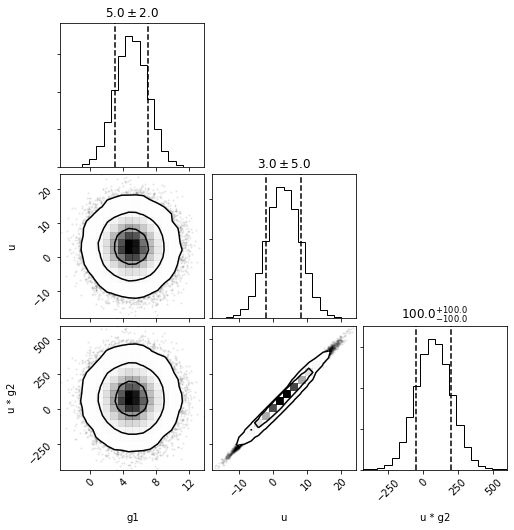

In [26]:
out = dc.plot(show=True)

Because the [DistributionCollection](../api/DistributionCollection.md) contains a [Composite](../api/Composite.md) distribution, we can either pass the two exposed values and `as_univariates=True` or the three underlying values without.

In [27]:
dc.labels

['g1', 'u', 'u * g2']

In [28]:
dc.pdf([6, 4, 4*25], as_univariates=True)

4.304601517213468e-05

In [29]:
dc.get_distributions_with_values([6, 4, 4*25], as_univariates=True)

{<distl.gaussian loc=5.0 scale=2.0 label=g1>: 6,
 <distl.gaussian loc=3.0 scale=5.0 label=u>: 4,
 <distl.composite {u} * {g2} unit=None>: 100}

In [30]:
g1.pdf(6) * u.pdf(4) * (u*g2).pdf(4*25)

4.304601517213468e-05

If not passing `as_univariates=True`, then we must pass a value for each of the unpacked underlying distributions.  Note that here 'u' is both an independent distribution as well as part of 'u * g2' so must be sent twice (and *must* be sent as the same value or an error will be raised).

Note that under-the-hood the separate passed values for 'u' are checked to make sure they're identical, but are then only included once in the returned probability.

In [31]:
dc.labels_unpacked

['g1', 'u', 'u', 'g2']

In [32]:
try:
    dc.pdf([6, 4, 5, 25])
except Exception as e:
    print(e)

All passed values for u must be identical


In [33]:
dc.pdf([6, 4, 4, 25])

0.00549234105537757

In [34]:
dc.get_distributions_with_values([6, 4, 4, 25])

{<distl.gaussian loc=5.0 scale=2.0 label=g1>: 6,
 <distl.gaussian loc=3.0 scale=5.0 label=u>: 4,
 <distl.gaussian loc=25.0 scale=1.0 label=g2>: 25}

In [35]:
g1.pdf(6) * u.pdf(4) * g2.pdf(25)

0.00549234105537757

# Composites containing MultivariateSlice distributions

Now let's consider a more complex example: let's sample from 'gaussian * mvg_a' and 'mvg_c'.  Here we want the covariance between 'mvg_a' and 'mvg_c' respected, even though there is a math operation on the result of 'mvg_a'.

In [36]:
dc = distl.DistributionCollection(g * mvg.slice('mvg_a'), mvg.slice('mvg_c'))

In [37]:
dc.sample()

array([36.65225264, 13.08855425])

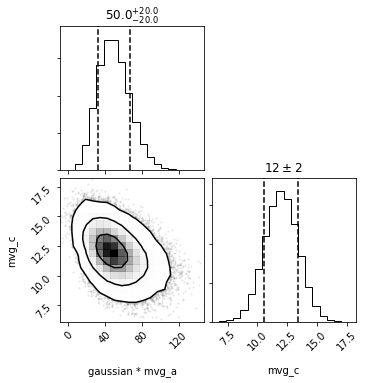

In [38]:
out = dc.plot(show=True)

As in the univariate case, [pdf](../api/DistributionCollection.pdf.md) takes a tuple/list/array.  However, in order to respect the covariances, the length of the input must match that of the underlying distributions that were sampled (see [labels_unpacked](../api/DistributionCollection.labels_unpacked.md) or [distributions_unpacked](../api/DistributionCollection.distributions_unpacked.md)).
